In [161]:
# Importando as bibliotecas necessárias
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

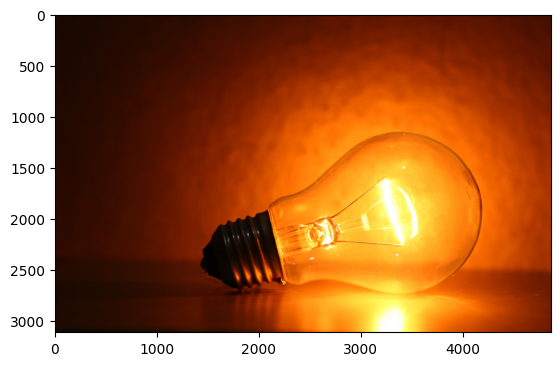

In [162]:

# Carregar a imagem
img = cv2.imread("../ImagensPDI/stockvault-bulb128619.jpg")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb,cmap='gray')

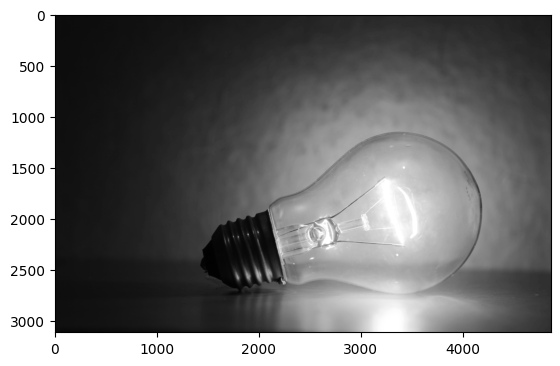

In [163]:
# Converter para escala de cinza
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

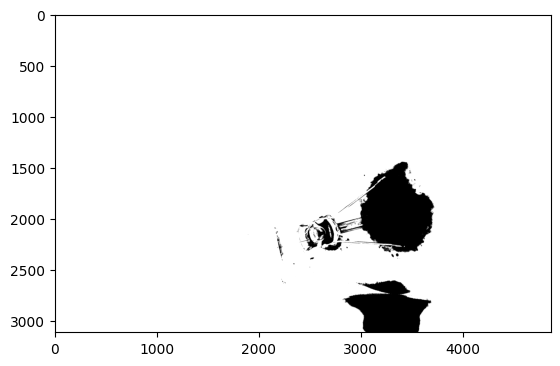

In [164]:
limear = 200
val,thresh = cv2.threshold(gray, limear, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap='gray')

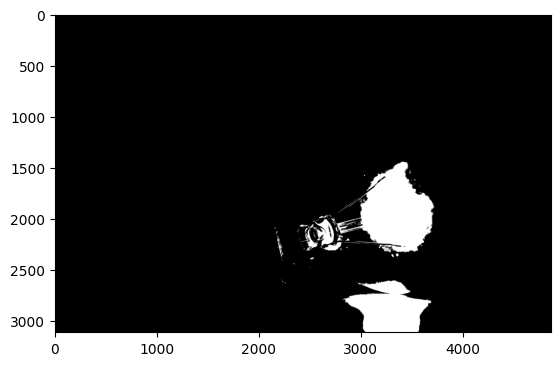

In [165]:

# Inverter a máscara para que a flor fique branca e o fundo preto
mask = cv2.bitwise_not(thresh)
plt.imshow(mask,cmap='gray')


In [166]:

# Remover pequenos ruídos e suavizar a máscara com operações de morfologia e desfocagem
kernel = np.ones((5,5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask = cv2.GaussianBlur(mask, (7, 7), 0)


In [167]:

# Converter a máscara para 3 canais para aplicá-la na imagem colorida
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# Aplicar a máscara na imagem original para manter apenas a flor
foreground = cv2.bitwise_and(rgb, mask_rgb)



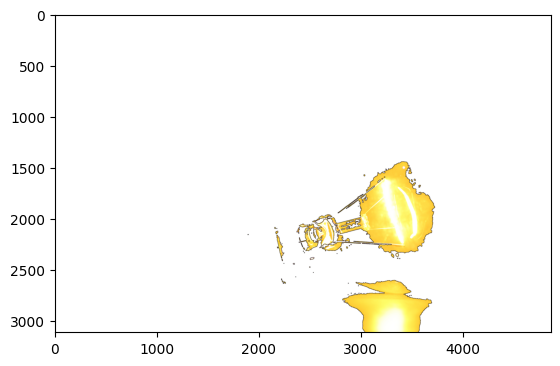

In [168]:

# Opcional: definir o fundo como branco ou preto
background = np.full_like(rgb, 255)  # Fundo branco
final_image = np.where(mask_rgb == 0, background, foreground)
# Exibir o resultado
plt.imshow(final_image)



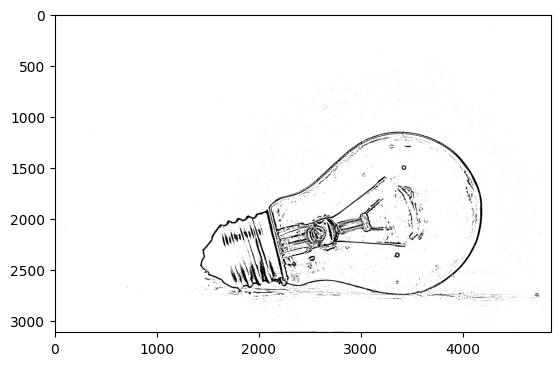

In [169]:
# Aplicar a limiarização adaptativa para obter uma máscara básica
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 3)
plt.imshow(thresh,cmap='gray')

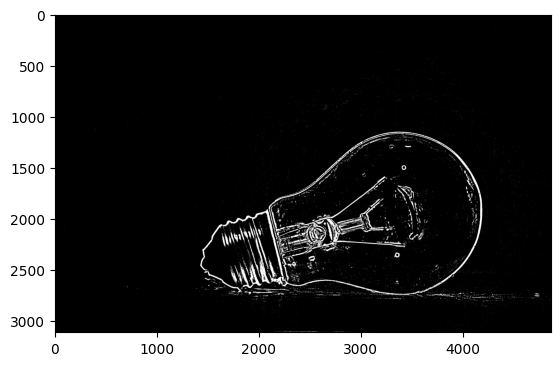

In [170]:
# Inverter a máscara para que a flor fique branca e o fundo preto
mask = cv2.bitwise_not(thresh)
plt.imshow(mask,cmap='gray')

In [171]:

# Remover pequenos ruídos e suavizar a máscara com operações de morfologia e desfocagem
kernel = np.ones((5,5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
mask = cv2.GaussianBlur(mask, (7, 7), 0)


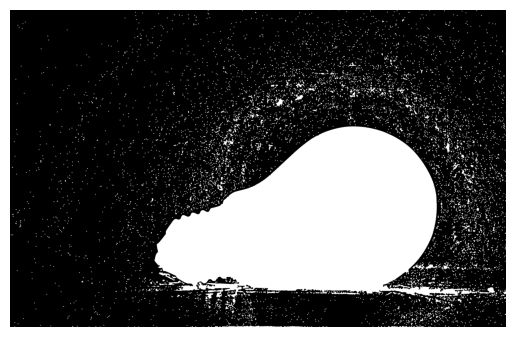

In [172]:

# Identificar contornos e criar uma máscara refinada
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_refined = np.zeros_like(mask)
cv2.drawContours(mask_refined, contours, -1, (255), thickness=cv2.FILLED)
plt.imshow(mask_refined, cmap='gray')

In [173]:
# Converter a máscara refinada para 3 canais para aplicá-la na imagem colorida
mask_rgb = cv2.cvtColor(mask_refined, cv2.COLOR_GRAY2RGB)

# Aplicar a máscara refinada na imagem original para manter apenas o objeto
foreground = cv2.bitwise_and(rgb, mask_rgb)



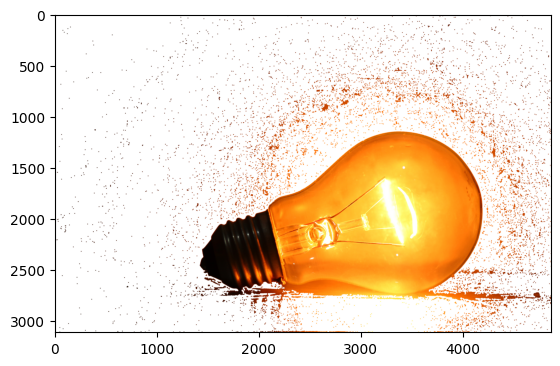

In [174]:

# Definir o fundo como branco ou preto
background = np.full_like(rgb, 255)  # Fundo branco
final_image = np.where(mask_rgb == 0, background, foreground)

# Exibir o resultado
plt.imshow(final_image)

In [179]:
# Carrega o modelo YOLO e aplica a segmentação na imagem
model = YOLO("../yolov8x-seg.pt")
results = model.track(img, persist=True)

# Cria uma máscara vazia com o mesmo tamanho da imagem original
combined_mask = np.zeros(img.shape[:2], dtype=np.uint8)

# Processa as detecções e gera a máscara combinada
for result in results:
    if result.masks is not None:
        for conf, mask in zip(result.boxes.conf, result.masks.data):
            if conf > 0.15:
                # Converte e redimensiona a máscara para o tamanho da imagem
                mask_np = mask.cpu().numpy()
                mask_resized = cv2.resize(mask_np, (img.shape[1], img.shape[0])).astype(np.uint8) * 255
                combined_mask = cv2.bitwise_or(combined_mask, mask_resized)

# Aplica a máscara na imagem original para remover o fundo
masked_img = cv2.bitwise_and(img, img, mask=combined_mask)



0: 416x640 1 apple, 1 cake, 1 dining table, 1 mouse, 118.4ms
Speed: 1.8ms preprocess, 118.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Imagem segmentada salva como 'imagem_segmentada.png'.


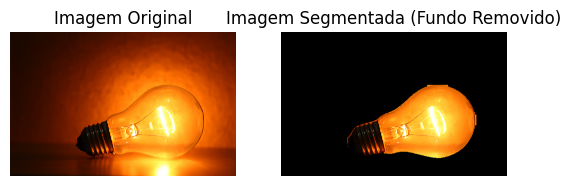

In [180]:
# Exibe a imagem original e a imagem segmentada
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Imagem Segmentada (Fundo Removido)")
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
